In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Add, LeakyReLU, GlobalAveragePooling2D, Multiply, Lambda, Reshape
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
PATH = '/kaggle/input/utkface-new/UTKFace'

In [3]:
image_paths = []
age_labels = []

for filename in os.listdir(PATH):
    image_path = os.path.join(PATH, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

In [4]:
image_paths = np.array(image_paths)
age_labels = np.array(age_labels)

In [5]:
low_res_images = []
high_res_images = []

for image_path in image_paths:
    img = load_img(image_path, target_size=(128, 128))
    img_array_high = img_to_array(img)
    
    img_low_res = load_img(image_path, target_size=(32, 32))
    img_array_low = img_to_array(img_low_res)
    
    high_res_images.append(img_array_high)
    low_res_images.append(img_array_low)

In [6]:
low_res_images = np.array(low_res_images) / 255.0
high_res_images = np.array(high_res_images) / 255.0

In [7]:
X_train_lr, X_testval_lr, y_train_hr, y_testval_hr, age_labels_train, age_labels_testval = train_test_split(
    low_res_images, high_res_images, age_labels, test_size=0.2, random_state=42
)
X_val_lr, X_test_lr, y_val_hr, y_test_hr, age_labels_val, age_labels_test = train_test_split(
    X_testval_lr, y_testval_hr, age_labels_testval, test_size=0.5, random_state=42
)

In [8]:
# Channel Attention Module
def channel_attention(x, reduction_ratio=16):
    channel = x.shape[-1]
    
    # Global Average Pooling
    avg_pool = GlobalAveragePooling2D()(x)
    
    # Reshape for dense operations
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    
    # FC layers using Conv2D
    fc1 = Conv2D(channel // reduction_ratio, kernel_size=1, use_bias=True)(avg_pool)
    fc1 = LeakyReLU(negative_slope=0.2)(fc1)
    fc2 = Conv2D(channel, kernel_size=1, use_bias=True)(fc1)
    
    # Activation
    scale = Activation('sigmoid')(fc2)
    
    return Multiply()([x, scale])

In [9]:
# Residual Channel Attention Block (RCAB)
def RCAB(x, filters, reduction_ratio=16):
    res = Conv2D(filters, kernel_size=3, padding='same')(x)
    res = LeakyReLU(negative_slope=0.2)(res)
    res = Conv2D(filters, kernel_size=3, padding='same')(res)
    
    # Channel attention
    res = channel_attention(res, reduction_ratio)
    
    # Skip connection
    res = Add()([x, res])
    return res

In [10]:
# Residual Group (RG)
def RG(x, filters, n_RCAB=20):
    res = x
    for _ in range(n_RCAB):
        res = RCAB(res, filters)
    res = Conv2D(filters, kernel_size=3, padding='same')(res)
    res = Add()([x, res])
    return res

In [11]:
# Pixel Shuffle Layer
def pixel_shuffle(x, scale):
    return tf.nn.depth_to_space(x, scale)

In [12]:
# Create RCAN model
def create_rcan(input_shape, n_RG=10, n_RCAB=20, filters=64):
    inputs = Input(shape=input_shape)
    
    # Initial feature extraction
    x = Conv2D(filters, kernel_size=3, padding='same')(inputs)
    main_path = x
    
    # Residual Groups
    for _ in range(n_RG):
        x = RG(x, filters, n_RCAB)
    
    # After RGs
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = Add()([main_path, x])
    
    # Upsampling (32x32 -> 64x64 -> 128x128)
    for _ in range(2):  # Scale factor of 4 (2^2)
        x = Conv2D(filters * 4, kernel_size=3, padding='same')(x)
        x = Lambda(lambda x: pixel_shuffle(x, 2))(x)
        x = LeakyReLU(negative_slope=0.2)(x)
    
    # Final reconstruction
    outputs = Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)
    
    return Model(inputs, outputs)

rcan = create_rcan((32, 32, 3), n_RG=5, n_RCAB=10)  # Reduced number of RG and RCAB for faster training

In [13]:
# SSIM metric for model evaluation
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [14]:
rcan.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mse',
    metrics=[ssim_metric]
)

In [15]:
# Train RCAN
history_rcan = rcan.fit(
    X_train_lr, y_train_hr,
    validation_data=(X_val_lr, y_val_hr),
    epochs=20,
    batch_size=16,  # Smaller batch size due to larger model
    verbose=1
)

Epoch 1/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 197s 109ms/step - loss: 0.0121 - ssim_metric: 0.6012 - val_loss: 0.0019 - val_ssim_metric: 0.8343
Epoch 2/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 103s 86ms/step - loss: 0.0018 - ssim_metric: 0.8450 - val_loss: 0.0017 - val_ssim_metric: 0.8613
Epoch 3/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 103s 87ms/step - loss: 0.0016 - ssim_metric: 0.8641 - val_loss: 0.0014 - val_ssim_metric: 0.8715
Epoch 4/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 101s 86ms/step - loss: 0.0014 - ssim_metric: 0.8746 - val_loss: 0.0014 - val_ssim_metric: 0.8771
Epoch 5/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 101s 85ms/step - loss: 0.0013 - ssim_metric: 0.8801 - val_loss: 0.0013 - val_ssim_metric: 0.8826
Epoch 6/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 100s 85ms/step - loss: 0.0013 - ssim_metric: 0.8848 - val_loss: 0.0012 - val_ssim_metric: 0.8865
Epoch 7/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 102s 86ms/step - loss: 0.0012 - ssim_metric: 0.8884 - val_loss: 0.0012 - val_ssim_metric: 0.8899
Epoch 8/20
1186/1186 ━━━━━

In [16]:
test_metrics = rcan.evaluate(X_test_lr, y_test_hr, batch_size=32, verbose=1)
print(f"Test MSE: {test_metrics[0]:.4f}")  
print(f"Test SSIM: {test_metrics[1]:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 9.3249e-04 - ssim_metric: 0.9124
Test MSE: 0.0009
Test SSIM: 0.9129


In [17]:
# Upscale images using the trained RCAN model
X_train_upscaled = rcan.predict(X_train_lr)
X_val_upscaled = rcan.predict(X_val_lr)
X_test_upscaled = rcan.predict(X_test_lr)

593/593 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


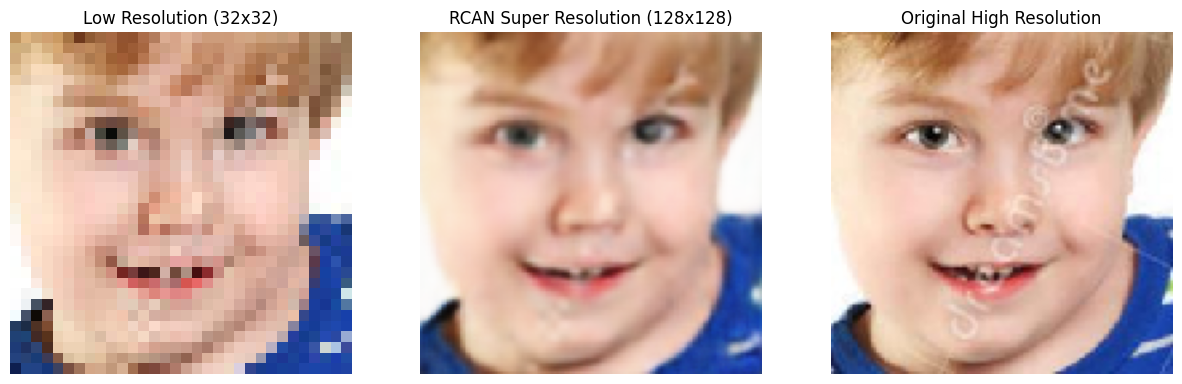

In [18]:
# Visualize results
index = 0
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Low Resolution (32x32)")
plt.imshow(X_test_lr[index])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("RCAN Super Resolution (128x128)")
plt.imshow(X_test_upscaled[index])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Original High Resolution")
plt.imshow(y_test_hr[index])
plt.axis('off')
plt.show()

In [19]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train_upscaled)

In [20]:
def create_regression_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    
    predicted_age = Dense(1, activation='linear', name='age_out')(x)
    return Model(inputs=inputs, outputs=predicted_age)

regression_model = create_regression_model((128, 128, 3))

In [21]:
regression_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [22]:
# Callbacks
model_save_path = '/kaggle/working/rcan_regression_model.keras'
regression_model.save(model_save_path)

checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [23]:
history_regression = regression_model.fit(
    datagen.flow(X_train_upscaled, age_labels_train, batch_size=32),
    validation_data=(X_val_upscaled, age_labels_val),
    epochs=100,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 71s 112ms/step - loss: 473.5034 - mae: 16.5865 - val_loss: 332.2237 - val_mae: 14.7549 - learning_rate: 0.0010
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 62s 104ms/step - loss: 315.7230 - mae: 13.6329 - val_loss: 246.4770 - val_mae: 11.9624 - learning_rate: 0.0010
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 62s 103ms/step - loss: 262.3727 - mae: 12.3350 - val_loss: 256.5740 - val_mae: 11.4684 - learning_rate: 0.0010
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - loss: 233.0362 - mae: 11.4626 - val_loss: 192.2695 - val_mae: 9.9889 - learning_rate: 0.0010
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 62s 104ms/step - loss: 207.5002 - mae: 10.8822 - val_loss: 166.4119 - val_mae: 9.4792 - learning_rate: 0.0010
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 62s 103ms/step - loss: 184.4282 - mae: 10.2254 - val_loss: 176.0808 - val_mae: 10.1607 - learning_rate: 0.0010
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - loss: 173.8281 - mae: 9.9641 - val_loss: 139

In [24]:
model = tf.keras.models.load_model('/kaggle/working/rcan_regression_model.keras')

In [25]:
y_pred = model.predict(X_test_upscaled, verbose=1)

mse = mean_squared_error(age_labels_test, y_pred)
mae = mean_absolute_error(age_labels_test, y_pred)
r2 = r2_score(age_labels_test, y_pred)

print(f"Regression Mean Squared Error (MSE): {mse:.4f}")
print(f"Regression Mean Absolute Error (MAE): {mae:.4f}")
print(f"Regression R² Score: {r2:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Regression Mean Squared Error (MSE): 75.3740
Regression Mean Absolute Error (MAE): 6.2617
Regression R² Score: 0.8063


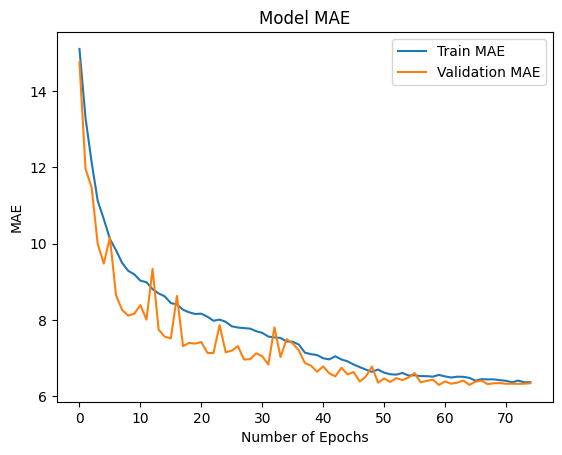

In [26]:
# Plot MAE
plt.plot(history_regression.history['mae'], label='Train MAE')
plt.plot(history_regression.history['val_mae'], label='Validation MAE')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('MAE')
plt.title('Model MAE')
plt.show()

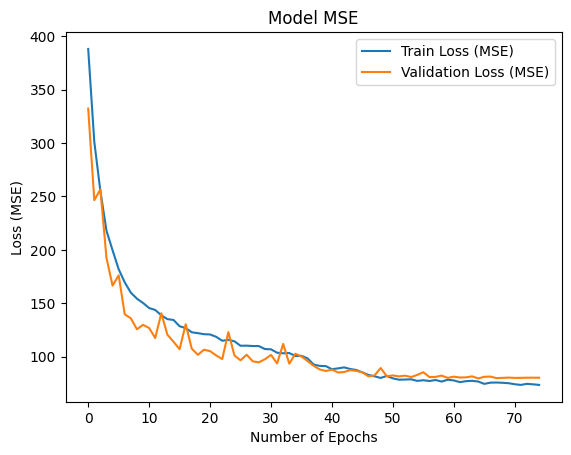

In [27]:
# Plot Loss (MSE)
plt.plot(history_regression.history['loss'], label='Train Loss (MSE)')
plt.plot(history_regression.history['val_loss'], label='Validation Loss (MSE)')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model MSE')
plt.show()